# ROC analysis


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc

#from statannotations.Annotator import Annotator
import allen_utils as allen


In [2]:
FIGURE_PATH = r'M:\analysis\Myriam_Hamon\results\roc_analysis'

# Load ROC data for all mice 
#### Find all files:

In [3]:
mouse_info_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis','Myriam_Hamon', 'mice_info')
mouse_info_df = pd.read_excel(os.path.join(mouse_info_path, 'mouse_reference_weight.xlsx')) # load mouse info file

data_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis', 'Myriam_Hamon', 'results')
roc_results_files = glob.glob(os.path.join(data_path, '**', '*_roc_results.csv'), recursive=True) # find all roc results files


In [4]:
print('Number of ROC files', len(roc_results_files))

Number of ROC files 18


#### Check out content of results:

In [5]:
roc_df = pd.concat([pd.read_csv(f) for f in roc_results_files], ignore_index=True) # concatenate all roc results files
# Use the reward group column of mouse_info_df to add the reward group to roc_df
mouse_info_df = mouse_info_df.rename(columns={'mouse_name': 'mouse_id'})

roc_df = roc_df.merge(mouse_info_df[['mouse_id', 'reward_group']], on='mouse_id', how='left')
print('Present mice:', roc_df['mouse_id'].unique(), 'Number of mice', roc_df['mouse_id'].nunique(), 'per reward group',  roc_df.groupby('reward_group')['mouse_id'].nunique()) 
print(roc_df['analysis_type'].unique())

excluded_mice = ['AB077','AB082']
roc_df = roc_df[~roc_df['mouse_id'].isin(excluded_mice)]

Present mice: ['MH030' 'MH034' 'MH035' 'MH001' 'MH029' 'MH026' 'MH019' 'MH028' 'MH037'
 'MH020' 'MH021' 'MH023' 'MH036' 'MH027' 'MH038' 'MH032' 'MH031' 'MH022'] Number of mice 18 per reward group reward_group
R+    11
R-     7
Name: mouse_id, dtype: int64
['whisker_passive_pre' 'whisker_passive_post' 'whisker_active'
 'whisker_pre_vs_post_learning' 'auditory_passive_pre'
 'auditory_passive_post' 'auditory_active' 'auditory_pre_vs_post_learning'
 'wh_vs_aud_passive_pre' 'wh_vs_aud_passive_post' 'wh_vs_aud_active'
 'wh_vs_aud_pre_vs_post_learning' 'spontaneous_licks']


In [6]:
print('Analysis types', roc_df['analysis_type'].unique())

Analysis types ['whisker_passive_pre' 'whisker_passive_post' 'whisker_active'
 'whisker_pre_vs_post_learning' 'auditory_passive_pre'
 'auditory_passive_post' 'auditory_active' 'auditory_pre_vs_post_learning'
 'wh_vs_aud_passive_pre' 'wh_vs_aud_passive_post' 'wh_vs_aud_active'
 'wh_vs_aud_pre_vs_post_learning' 'spontaneous_licks']


# Data selection
#### Process area names

In [7]:
#roc_df = create_area_custom_column(roc_df)
roc_df = allen.create_area_custom_column(roc_df)

In [8]:
roc_df.columns

Index(['mouse_id', 'unit_id', 'cluster_id', 'firing_rate', 'ccf_acronym',
       'ccf_name', 'ccf_parent_acronym', 'ccf_parent_id', 'ccf_parent_name',
       'analysis_type', 'area', 'auc', 'selectivity', 'fpr', 'tpr',
       'thresholds', 'significant', 'direction', 'p_value', 'p_value_to_show',
       'reward_group', 'area_acronym_custom'],
      dtype='object')

#### Check out number of neurons, total

In [9]:
df_counts = roc_df.groupby(['analysis_type'])['area_acronym_custom'].value_counts().reset_index()
df_counts = df_counts[df_counts.analysis_type=='whisker_active']
df_counts

,analysis_type,area_acronym_custom,count
396,whisker_active,MOs,688
397,whisker_active,MOp,616
398,whisker_active,CP,531
399,whisker_active,SCm,478
400,whisker_active,MRN,363
401,whisker_active,CA3,321
402,whisker_active,DG,287
403,whisker_active,AI,280
404,whisker_active,LGN,280
405,whisker_active,LS,264


#### Plot number of neurons to compare with ROC analyses

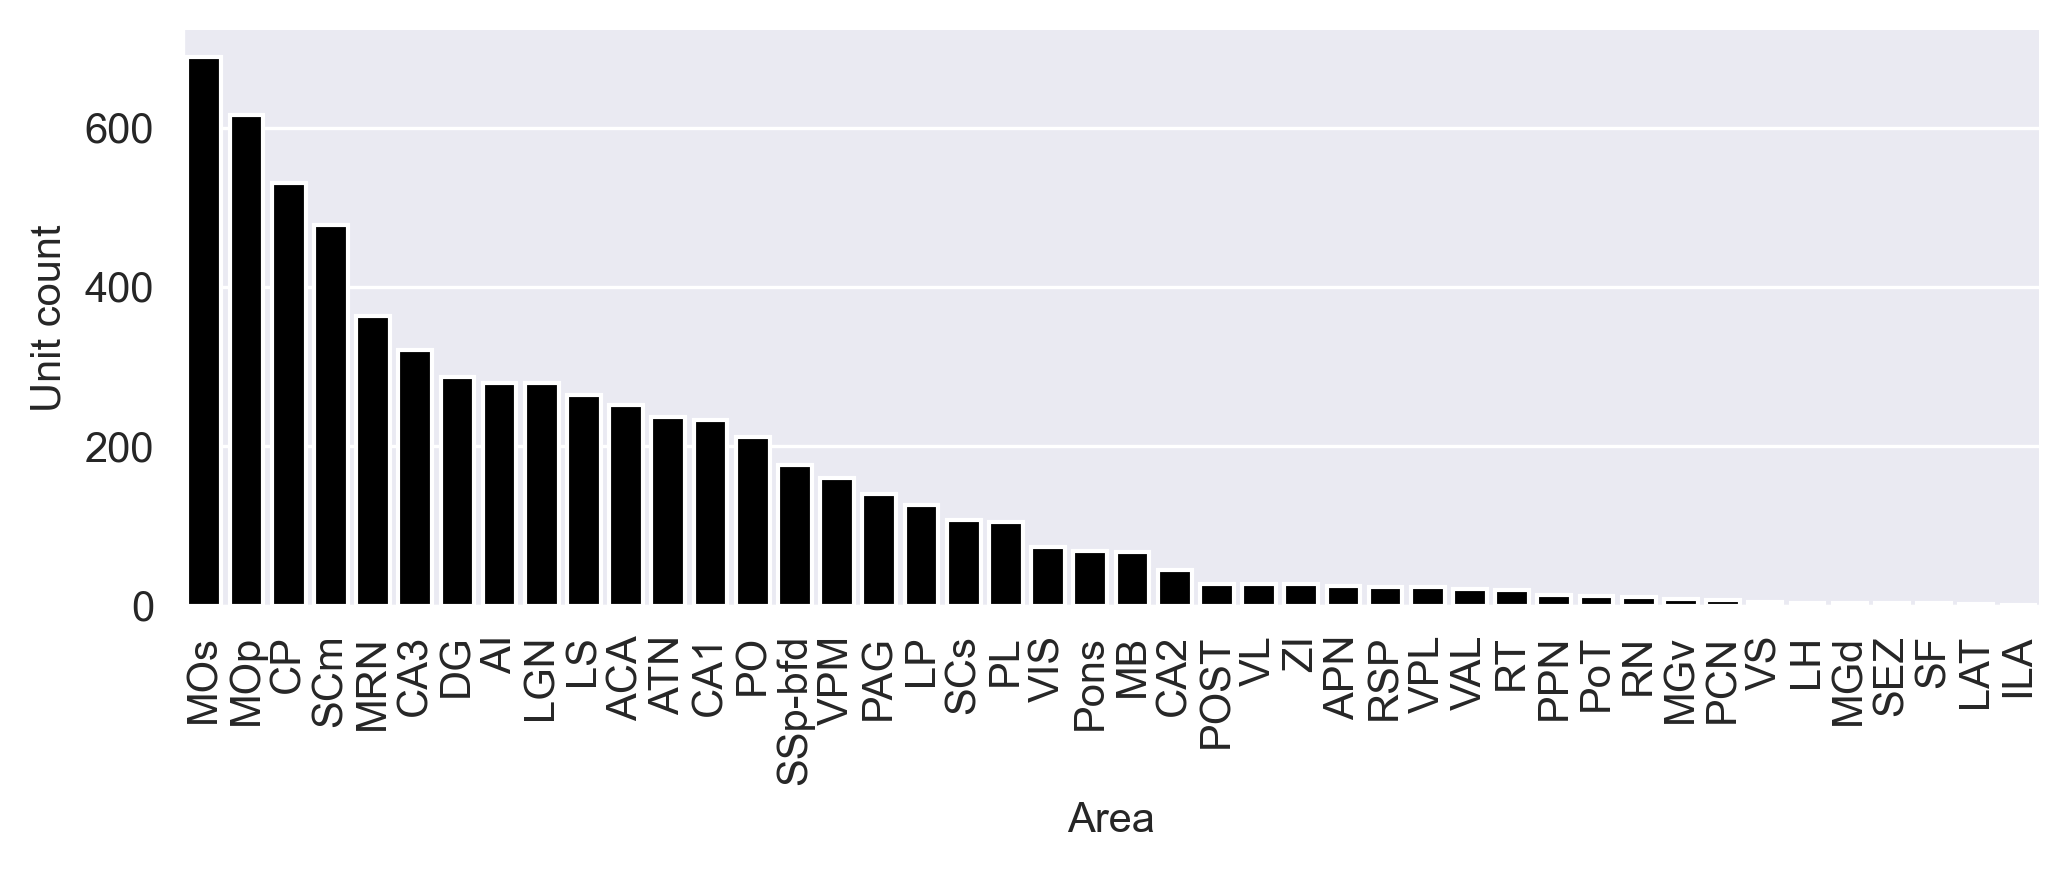

In [10]:
df_counts = roc_df.groupby(['analysis_type'])['area_acronym_custom'].value_counts().reset_index()
df_counts = df_counts[df_counts.analysis_type=='whisker_passive_post']
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=300)
sns.barplot(data=df_counts,
            ax=ax,
            x='area_acronym_custom',
            y='count',
            color='k')
sns.despine()
ax.set_xticks(labels=df_counts['area_acronym_custom'], ticks=ax.get_xticks(), rotation=90)
ax.set_ylabel('Unit count')
ax.set_xlabel('Area')
fig.tight_layout()
fname = 'roc_neuron_count_passivemice.png'
#fig.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches='tight')

In [11]:
# Keep areas with at least N single units
N_UNITS_MIN = 10

# Count the number of occurrences per 'area_custom' grouped by 'analysis_type'
area_counts_by_analysis = roc_df.groupby(['analysis_type', 'area_acronym_custom']).size()

# Filter to retain only areas with counts above the threshold
valid_areas = area_counts_by_analysis[area_counts_by_analysis >= N_UNITS_MIN].index

# Subset the DataFrame to include only the valid areas
roc_df_subset = roc_df[roc_df.set_index(['analysis_type', 'area_acronym_custom']).index.isin(valid_areas)]

# Verify the counts in the subset
area_counts_subset = roc_df_subset.groupby(['analysis_type', 'area_acronym_custom']).size()
print(area_counts_subset)

# Find set of areas shared by R+ and R-
rplus_areas = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].unique()
rmins_areas = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].unique()
shared_areas = list(set(rplus_areas).intersection(rmins_areas))

n_rplus_areas = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].nunique()
n_rmins_areas = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].nunique()
print('Number of areas in R+:', n_rplus_areas, 'Number of areas in R-:', n_rmins_areas, 'Number of shared areas:', len(shared_areas))

rplus_areas_count = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].value_counts()
rmins_areas_count = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].value_counts()

print('Shared areas', shared_areas)
    

analysis_type                 area_acronym_custom
auditory_active               ACA                    252
                              AI                     280
                              APN                     25
                              ATN                    237
                              CA1                    233
                                                    ... 
whisker_pre_vs_post_learning  VIS                     73
                              VL                      27
                              VPL                     24
                              VPM                    160
                              ZI                      27
Length: 455, dtype: int64
Number of areas in R+: 32 Number of areas in R-: 25 Number of shared areas: 22
Shared areas ['PAG', 'MOs', 'DG', 'LS', 'ATN', 'CA2', 'PO', 'LGN', 'VL', 'MOp', 'SSp-bfd', 'CP', 'CA1', 'CA3', 'AI', 'MRN', 'VPM', 'RN', 'MB', 'SCs', 'SCm', 'Pons']


# Start with an example area
SSp-bfd

In [12]:
ex_area = 'SSp-bfd'
roc_df_single_area = roc_df_subset[roc_df_subset['area_acronym_custom'] == ex_area]
roc_df_single_area['mouse_id'].unique()

array(['MH034', 'MH029', 'MH037', 'MH023', 'MH038', 'MH031'], dtype=object)

In [13]:
roc_df_single_area.head(2)

,mouse_id,unit_id,cluster_id,firing_rate,ccf_acronym,ccf_name,ccf_parent_acronym,ccf_parent_id,ccf_parent_name,analysis_type,...,selectivity,fpr,tpr,thresholds,significant,direction,p_value,p_value_to_show,reward_group,area_acronym_custom
12477,MH034,290,350,2.704737,SSp-bfd-D8-6a,"Primary somatosensory area, barrel field, D8 b...",SSp-bfd-D8,614454432.0,"Primary somatosensory area, barrel field, D8 b...",whisker_passive_pre,...,0.080210,[0. 0. 0.02564103 0.05128205 0...,[0. 0.05128205 0.05128205 0.07692308 0...,[inf 4. 3. 2. 1. 0.],False,NaN,0.24,0.24,R-,SSp-bfd
12478,MH034,292,352,5.054965,SSp-bfd-D8-6a,"Primary somatosensory area, barrel field, D8 b...",SSp-bfd-D8,614454432.0,"Primary somatosensory area, barrel field, D8 b...",whisker_passive_pre,...,-0.274819,[0. 0.02564103 0.20512821 0.66666667 1...,[0. 0. 0.1025641 0.41025641 1...,[inf 4. 2. 1. 0.],True,negative,0.03,0.03,R-,SSp-bfd


In [14]:
# Calculate the total neuron count per analysis type and per reward group
total_neurons_per_group = (
    roc_df_single_area.groupby(['analysis_type', 'reward_group'])
    .size()
    .reset_index(name='total_count')
)

# Group by direction and calculate selective counts
selective_counts = (
    roc_df_single_area[roc_df_single_area['significant']]  # Filter for selective neurons
    .groupby(['analysis_type', 'reward_group', 'direction'])
    .size()
    .reset_index(name='count')
)

# Add non-selective counts
non_selective_counts = (
    roc_df_single_area[~roc_df_single_area['significant']]  # Filter for non-selective neurons
    .groupby(['analysis_type', 'reward_group']) # no direction because assignment below
    .size()
    .reset_index(name='count')
)
non_selective_counts['direction'] = 'non-selective'

# Combine selective and non-selective counts
roc_df_single_area_perc = pd.concat([selective_counts, non_selective_counts], ignore_index=True)

# Merge total neuron counts
roc_df_single_area_perc = roc_df_single_area_perc.merge(total_neurons_per_group, on=['analysis_type', 'reward_group'])

# Calculate proportions
roc_df_single_area_perc['proportion'] = (roc_df_single_area_perc['count'] / roc_df_single_area_perc['total_count']) * 100
roc_df_single_area_perc.head(5)

,analysis_type,reward_group,direction,count,total_count,proportion
0,auditory_active,R+,negative,2,103,1.941748
1,auditory_active,R+,positive,17,103,16.504854
2,auditory_active,R-,negative,5,73,6.849315
3,auditory_active,R-,positive,8,73,10.958904
4,auditory_passive_post,R+,negative,3,103,2.912621


In [15]:
roc_df_single_area_perc[roc_df_single_area_perc.analysis_type=='auditory_passive_post']

,analysis_type,reward_group,direction,count,total_count,proportion
4,auditory_passive_post,R+,negative,3,103,2.912621
5,auditory_passive_post,R+,positive,19,103,18.446602
6,auditory_passive_post,R-,negative,4,73,5.479452
7,auditory_passive_post,R-,positive,13,73,17.808219
54,auditory_passive_post,R+,non-selective,81,103,78.640777
55,auditory_passive_post,R-,non-selective,56,73,76.712329


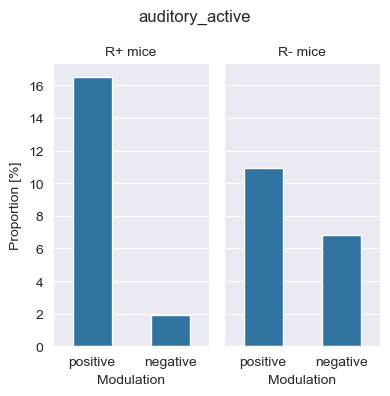

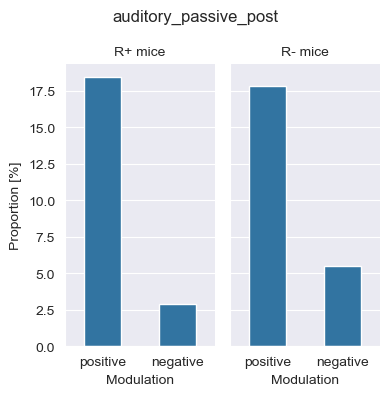

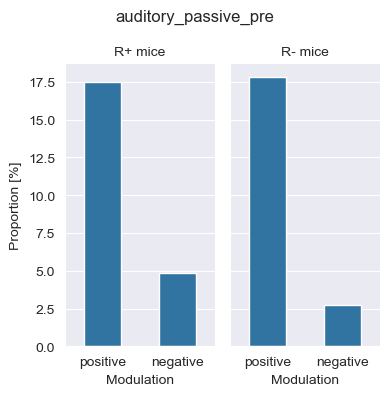

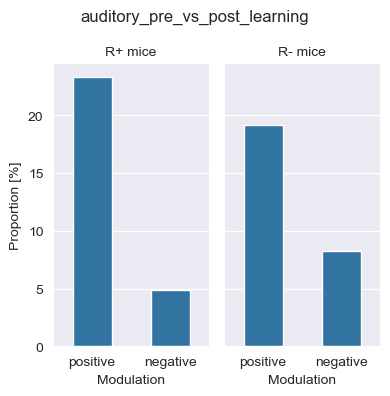

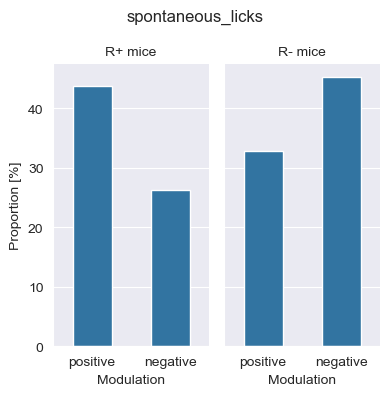

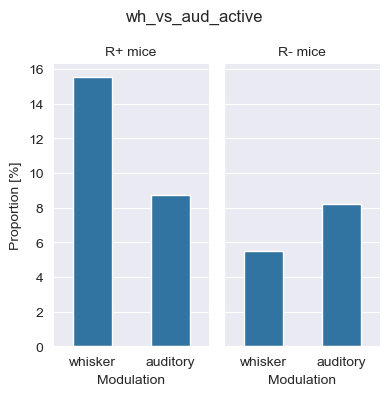

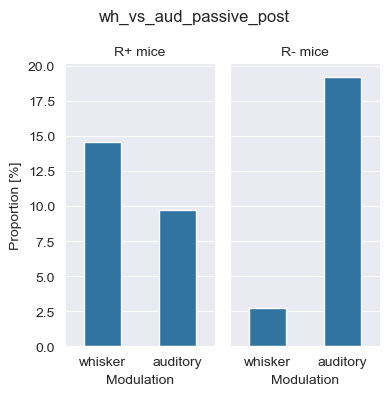

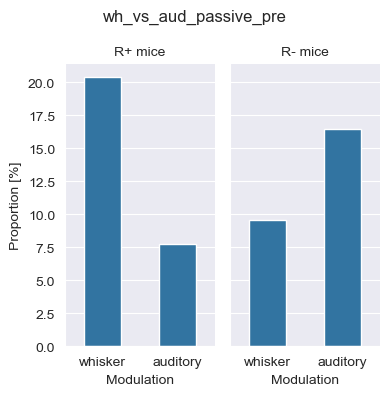

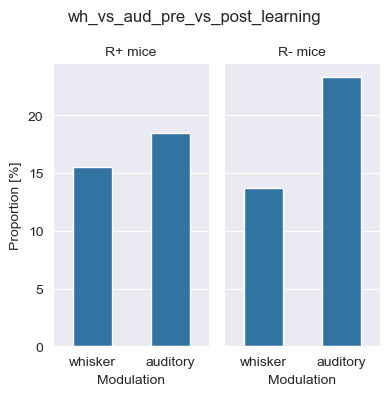

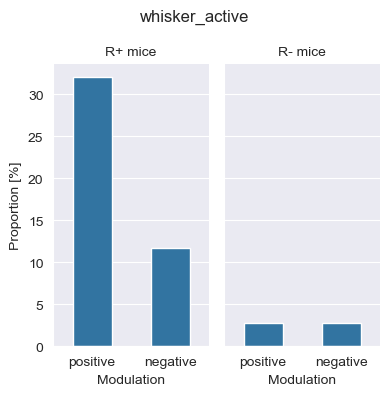

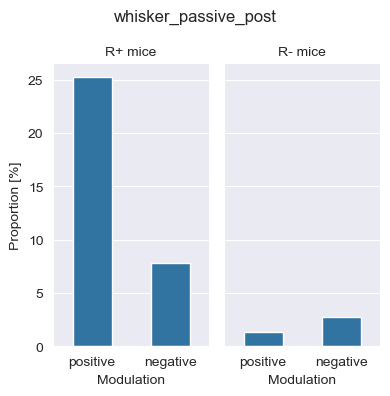

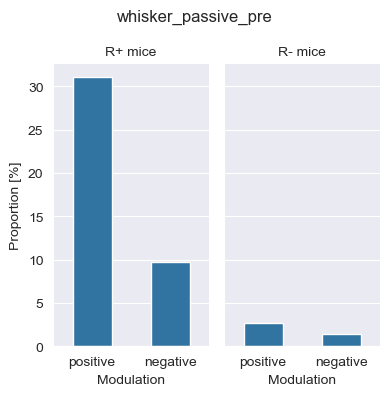

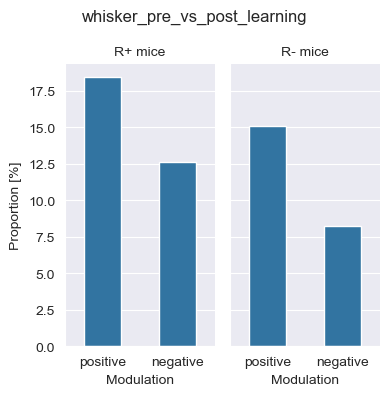

In [16]:
for anal_type in roc_df_single_area_perc['analysis_type'].unique():
    roc_prop_type = roc_df_single_area_perc[roc_df_single_area_perc['analysis_type']==anal_type]
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
    else:
        order=['positive', 'negative'] 
    g = sns.FacetGrid(roc_prop_type, col='reward_group', sharey=True, despine=True,height=4, aspect=.5)
    g.map(sns.barplot, 'direction', "proportion", order=order, dodge=True, width=0.5)
    g.figure.suptitle(anal_type)
    g.set_axis_labels('Modulation', 'Proportion [%]')
    g.set_titles(col_template="{col_name} mice")
    g.tight_layout()


    fname = f'{ex_area}_{anal_type}_direction.png'
    #g.savefig(os.path.join(FIGURE_PATH, fname))

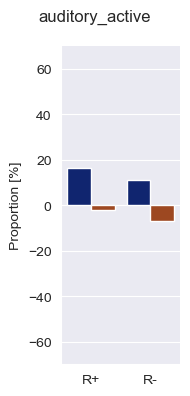

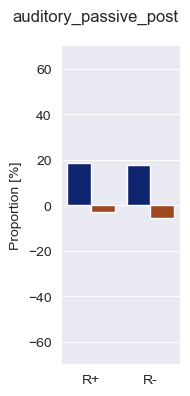

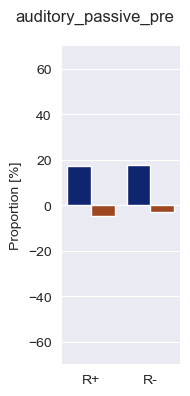

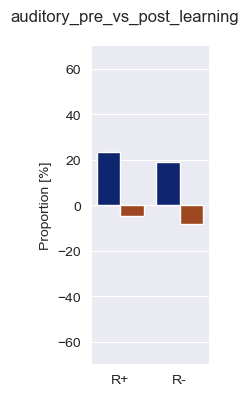

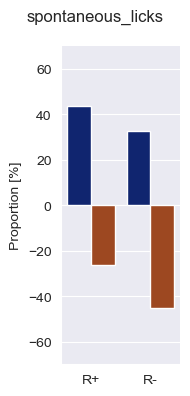

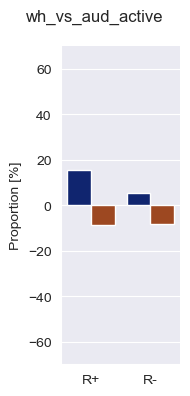

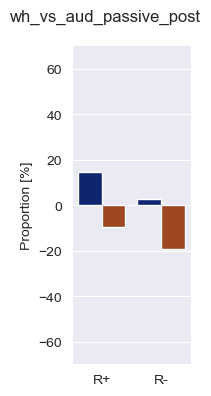

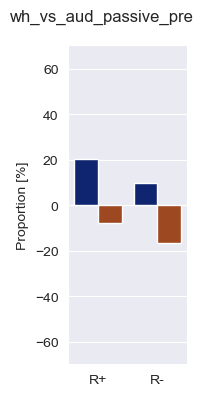

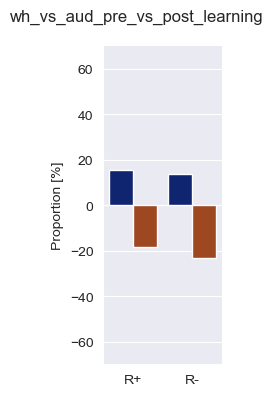

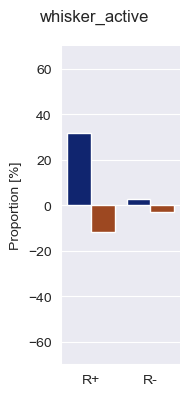

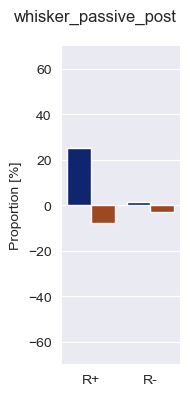

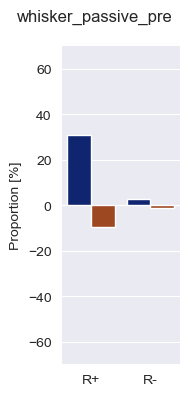

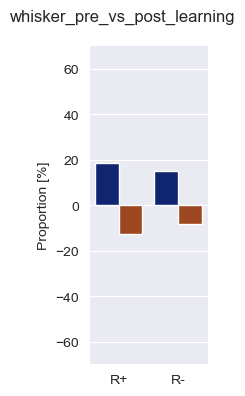

In [17]:
# Make a double sided plot - invert the sign for negative and auditory directions
roc_df_single_area_perc['proportion_signed'] = roc_df_single_area_perc['proportion']
roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('negative'), 'proportion_signed'] = (-1)*roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('negative'), 'proportion']
roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('auditory'), 'proportion_signed'] = (-1)*roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('auditory'), 'proportion']

for anal_type in roc_df_single_area_perc['analysis_type'].unique():
    roc_prop_type = roc_df_single_area_perc[roc_df_single_area_perc['analysis_type']==anal_type]
   
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
    else:
        order=['positive', 'negative'] 

    g = sns.catplot(
        data=roc_prop_type, 
        kind='bar',
        x='reward_group',
        y='proportion_signed',
        order=['R+','R-'], 
        hue='direction',
        hue_order=order,
        errorbar=None, 
        palette='dark', 
        height=4,
        aspect=0.5,
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set_titles(col_template="{col_name} mice")
    g.set(ylim=(-70, 70))
    g.tight_layout()

    fname = f'{ex_area}_{anal_type}_direction_signed.png'
    #g.savefig(os.path.join(FIGURE_PATH, fname))

# Figures for all areas
#### First, create a customized area order, with associated colros

In [18]:
roc_df_shared_areas = roc_df_subset
roc_df_shared_areas['area_acronym_custom'].unique()
area_order = allen.get_custom_area_order()

# List all areas present vs area order list
missing = [a for a in shared_areas if a not in area_order]
area_order_shared = [a for a in area_order if a in shared_areas]

# Make a color dict for the group of areas
area_groups = allen.get_custom_area_groups()

# Keep areas that present in dataset
area_groups = {k: [i for i in v if i in area_order_shared] for k,v in area_groups.items()}
print(area_groups, len(area_groups.keys()))

# Generate a colormap with as many colors as the number of area groups
color_palette = plt.cm.tab20.colors  # Use the tab20 colormap for distinct colors
color_palette = ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#9ad2bd', '#f2483b']
color_palette_dict = allen.get_custom_area_groups_colors()
color_palette = list(color_palette_dict.values())




#colors = [[color] * len(list(area_groups.keys())[idx]) for idx,color in enumerate(color_palette)]
#colors = [x for xs in colors for x in xs]
#colors = [mc.rgb2hex(color_palette[i % len(color_palette)]) for i in range(len(area_groups))]
colors = [color_palette[i % len(color_palette)] for i in range(len(area_groups))] #hex
#colors = [mc.hex2color(color_palette[i % len(color_palette)]) for i in range(len(area_groups))] #rgb
print('Equality ensured', len(colors)==len(area_groups.keys()))

# Create a dictionary mapping each area to its group color
area_color_dict = {}
#area_color_dict = allen.get_custom_area_groups_colors()
for (group_name, areas), color in zip(area_groups.items(), colors):
    for area in areas:
        area_color_dict[area] = color
area_color_list = list(area_color_dict.values())


{'Motor and frontal areas': ['MOp', 'MOs', 'AI'], 'Somatosensory areas': ['SSp-bfd'], 'Auditory areas': [], 'Retrosplenial areas': [], 'Cortical subplate': [], 'Hippocampus': ['CA1', 'CA2', 'CA3', 'DG'], 'Striatal and pallidum': ['CP', 'LS'], 'Thalamus': ['VPM', 'PO', 'LGN', 'ATN'], 'Midbrain': ['SCs', 'SCm', 'MB', 'MRN', 'PAG', 'RN'], 'Pons': ['Pons'], 'Olfactory areas': [], 'Hypothalamus': []} 12
Equality ensured True


In [19]:
print('colors', colors)
print('dict', area_color_list, len(area_color_list))
print(area_order_shared, len(area_order_shared))

colors ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#ffc395', '#9ad2bd', '#f2483b']
dict ['#1f9d5a', '#1f9d5a', '#1f9d5a', '#188064', '#7ed04b', '#7ed04b', '#7ed04b', '#7ed04b', '#98d6f9', '#98d6f9', '#ff7080', '#ff7080', '#ff7080', '#ff7080', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ffc395'] 21
['MOp', 'MOs', 'AI', 'SSp-bfd', 'CA1', 'CA2', 'CA3', 'DG', 'CP', 'LS', 'VPM', 'PO', 'LGN', 'ATN', 'SCs', 'SCm', 'MB', 'MRN', 'PAG', 'RN', 'Pons'] 21


#### Compute proportion per area

In [20]:
# Calculate the total neuron count per analysis type and per reward group
total_neurons_per_group = (
    roc_df_shared_areas.groupby(['analysis_type', 'reward_group', 'area_acronym_custom'])
    .size()
    .reset_index(name='total_count')
)

# Group by direction and calculate selective counts
selective_counts = (
    roc_df_shared_areas[roc_df_shared_areas['significant']]  # Filter for selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom', 'direction'])
    .size()
    .reset_index(name='count')
)

# Add non-selective counts
non_selective_counts = (
    roc_df_shared_areas[~roc_df_shared_areas['significant']]  # Filter for non-selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom']) # no direction because assignment below
    .size()
    .reset_index(name='count')
)
non_selective_counts['direction'] = 'non-selective'

# Combine selective and non-selective counts
roc_df_shared_areas_perc = pd.concat([selective_counts, non_selective_counts], ignore_index=True)

# Merge total neuron counts
roc_df_shared_areas_perc = roc_df_shared_areas_perc.merge(total_neurons_per_group, on=['analysis_type', 'reward_group', 'area_acronym_custom'])

# Calculate proportions
roc_df_shared_areas_perc['proportion'] = (roc_df_shared_areas_perc['count'] / roc_df_shared_areas_perc['total_count']) * 100
roc_df_shared_areas_perc.head(5)

,analysis_type,reward_group,area_acronym_custom,direction,count,total_count,proportion
0,auditory_active,R+,ACA,negative,15,252,5.952381
1,auditory_active,R+,ACA,positive,54,252,21.428571
2,auditory_active,R+,AI,negative,3,71,4.225352
3,auditory_active,R+,AI,positive,4,71,5.633803
4,auditory_active,R+,APN,positive,17,25,68.000000


In [21]:
# Make a double sided plot - invert the sign for negative and auditory directions
roc_df_shared_areas_perc['proportion_signed'] = roc_df_shared_areas_perc['proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion']


In [22]:
len(area_color_list)

21

#### Make figure one group

C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\2888055515.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\2888055515.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\2888055515.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\2888055515.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

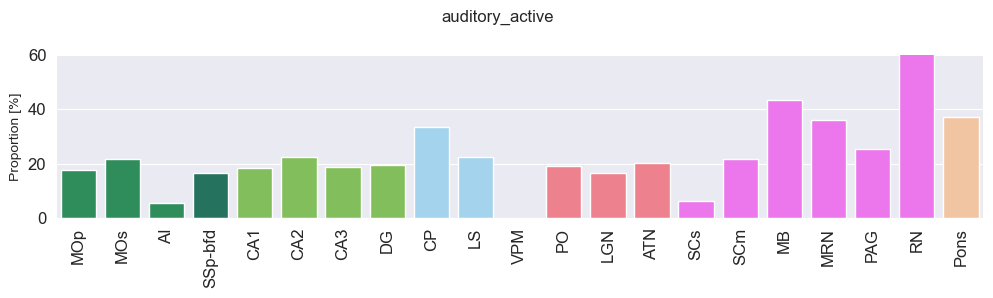

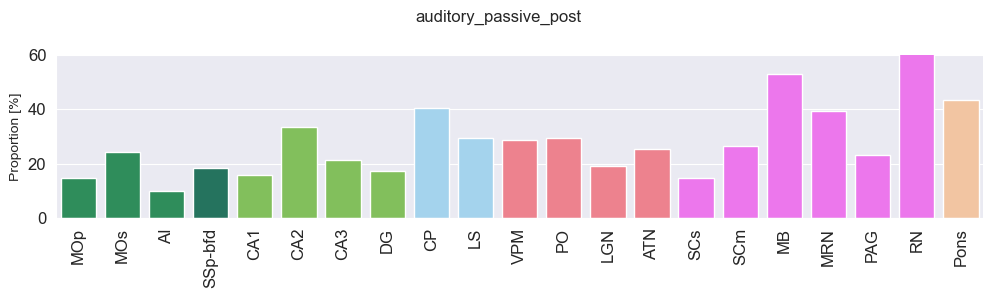

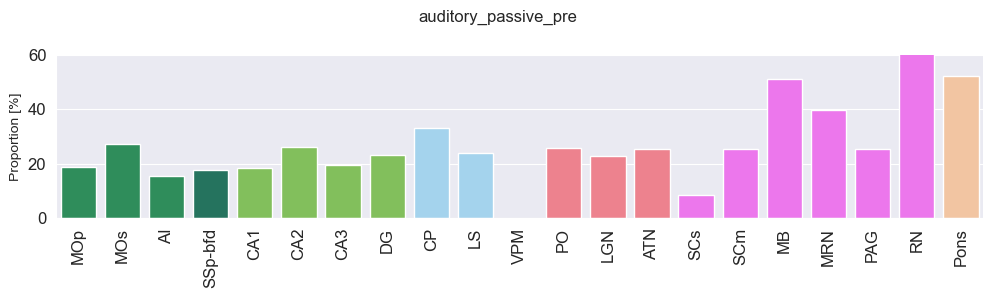

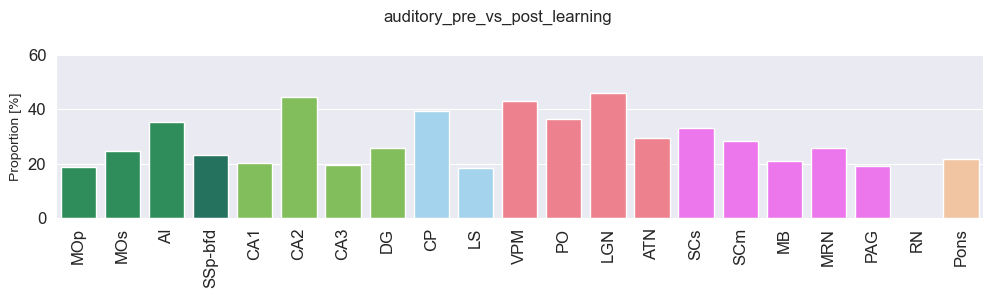

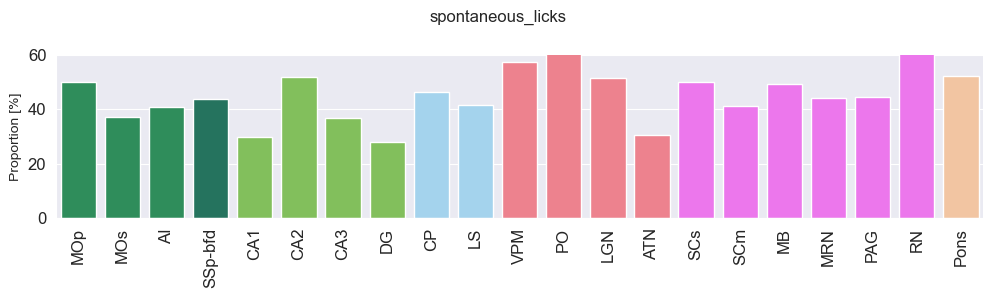

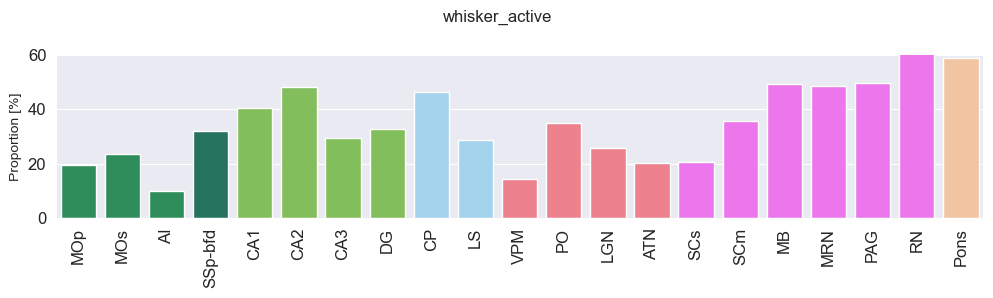

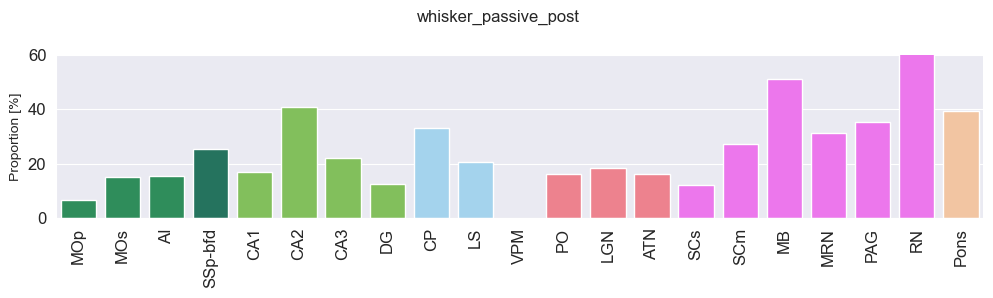

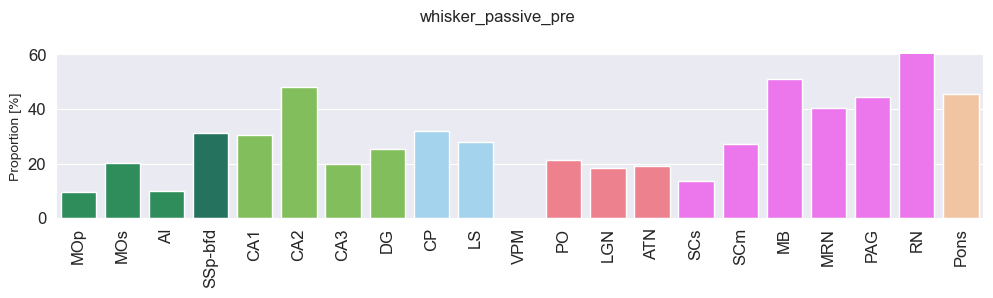

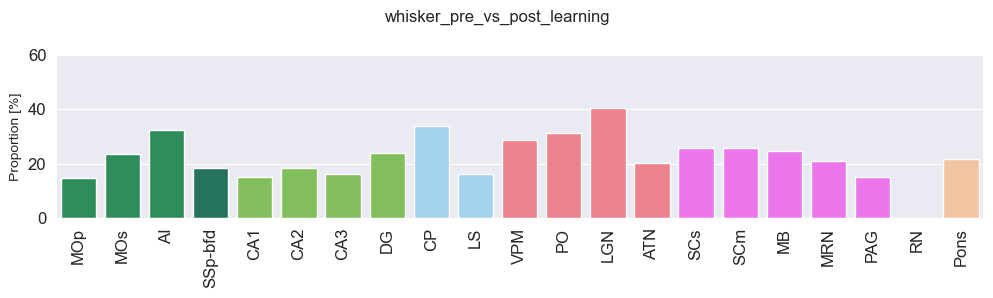

In [23]:
# Keep R+ rewarded mice only for now
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc[roc_df_shared_areas_perc.reward_group.eq('R+')]
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded.direction.eq('positive')]

for anal_type in roc_df_shared_areas_perc_rewarded['analysis_type'].unique():
    #fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    roc_df_all_areas_type = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded['analysis_type']==anal_type]
    
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
        suffix = 'auditory'
    else:
        order=['positive', 'negative'] 
        suffix = 'positive'
    g = sns.catplot(
        data=roc_df_all_areas_type, 
        kind='bar',
        x='area_acronym_custom',
        y='proportion_signed',
        order=area_order_shared, 
        palette=area_color_list,
        #color=area_color_list,
        #row='direction',
        #hue_order=order,
        height=2.5,
        aspect=4,
        errorbar=None, 
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set(ylim=(0, 60))
    g.tight_layout()
    g.set_xticklabels(rotation=90)
    g.tick_params(labelsize=12)
    
    figname = f'brainwide_roc_rplus_{anal_type}_{suffix}.svg'
    g.savefig(os.path.join(FIGURE_PATH, figname))
    
    

In [24]:
len(area_order_shared)

21

In [28]:
roc_df_all_areas_type['area_acronym_custom'].nunique()

31

In [26]:
roc_df_all_areas_type[roc_df_all_areas_type.area_custom=='LS']

AttributeError: 'DataFrame' object has no attribute 'area_custom'

In [31]:
roc_df_shared_areas_perc

,analysis_type,reward_group,area_acronym_custom,direction,count,total_count,proportion,proportion_signed
0,auditory_active,R+,ACA,negative,15,252,5.952381,-5.952381
1,auditory_active,R+,ACA,positive,54,252,21.428571,21.428571
2,auditory_active,R+,AI,negative,3,71,4.225352,-4.225352
3,auditory_active,R+,AI,positive,4,71,5.633803,5.633803
4,auditory_active,R+,APN,positive,17,25,68.000000,68.000000
...,...,...,...,...,...,...,...,...
2104,whisker_pre_vs_post_learning,R-,SSp-bfd,non-selective,56,73,76.712329,76.712329
2105,whisker_pre_vs_post_learning,R-,VL,non-selective,4,11,36.363636,36.363636
2106,whisker_pre_vs_post_learning,R-,VPL,non-selective,15,24,62.500000,62.500000
2107,whisker_pre_vs_post_learning,R-,VPM,non-selective,98,153,64.052288,64.052288


#### Make figure both groups

brainwide_roc_reward_groups_auditory_active_positive.png
brainwide_roc_reward_groups_auditory_passive_post_positive.png
brainwide_roc_reward_groups_auditory_passive_pre_positive.png
brainwide_roc_reward_groups_auditory_pre_vs_post_learning_positive.png
brainwide_roc_reward_groups_spontaneous_licks_positive.png
brainwide_roc_reward_groups_whisker_active_positive.png
brainwide_roc_reward_groups_whisker_passive_post_positive.png
brainwide_roc_reward_groups_whisker_passive_pre_positive.png
brainwide_roc_reward_groups_whisker_pre_vs_post_learning_positive.png


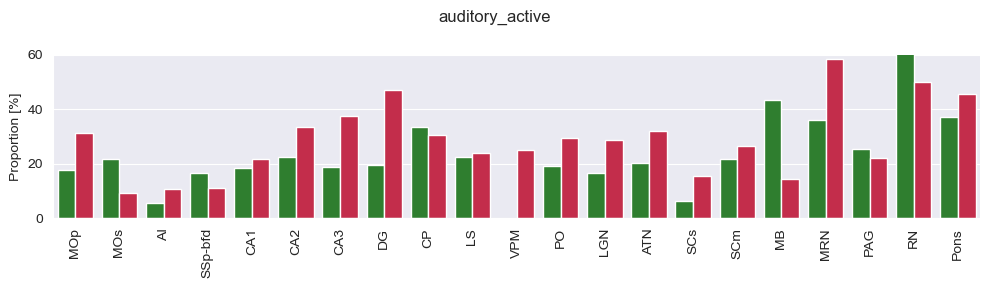

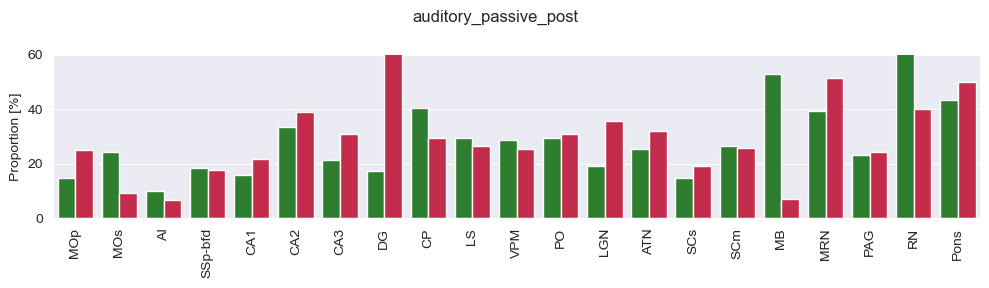

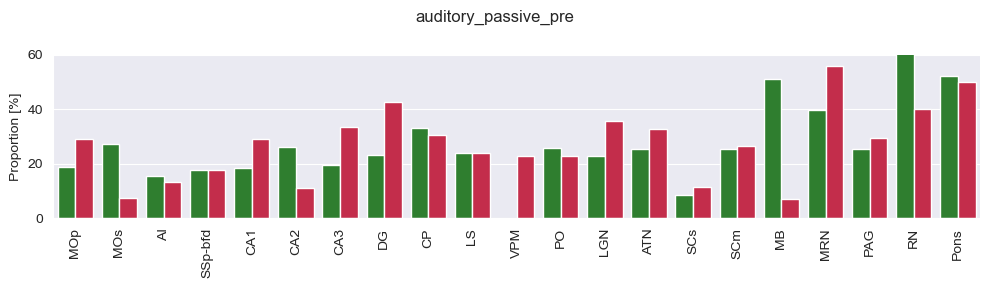

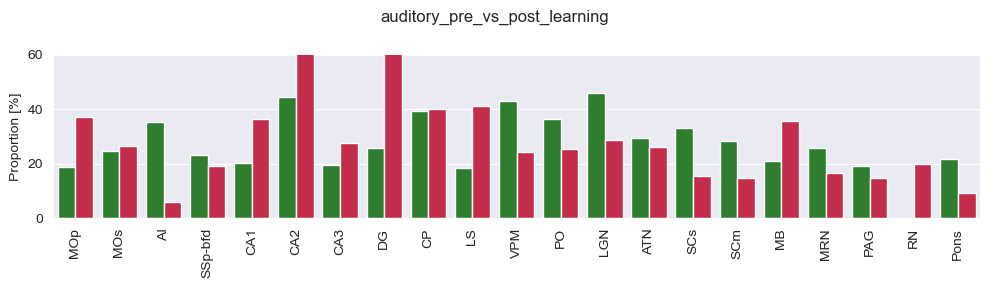

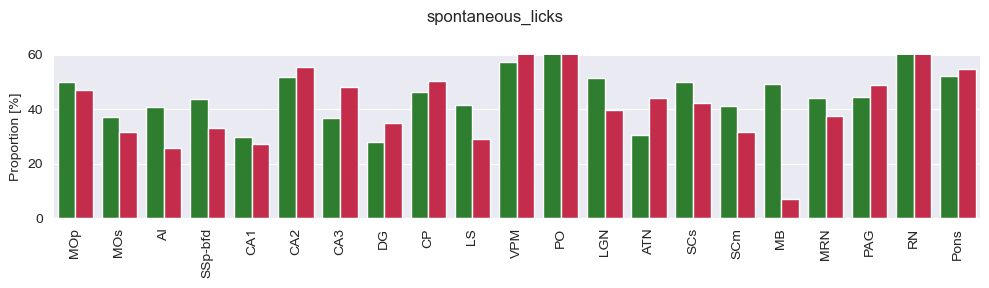

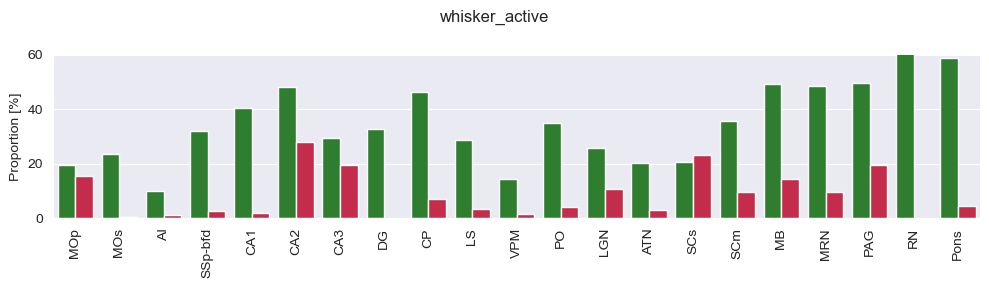

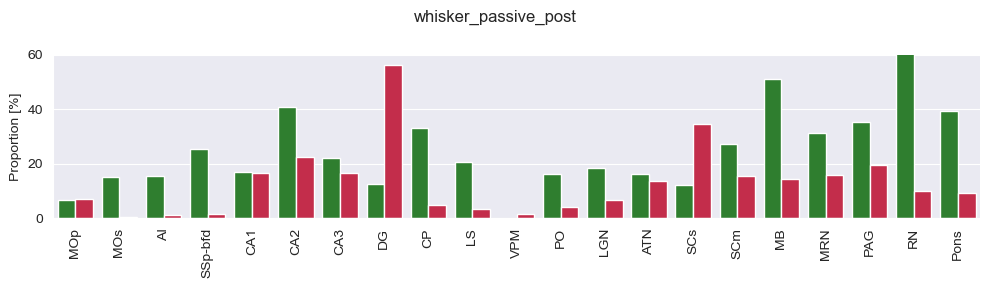

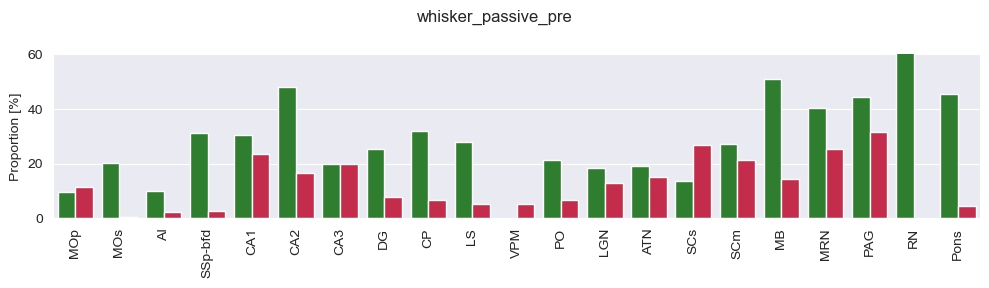

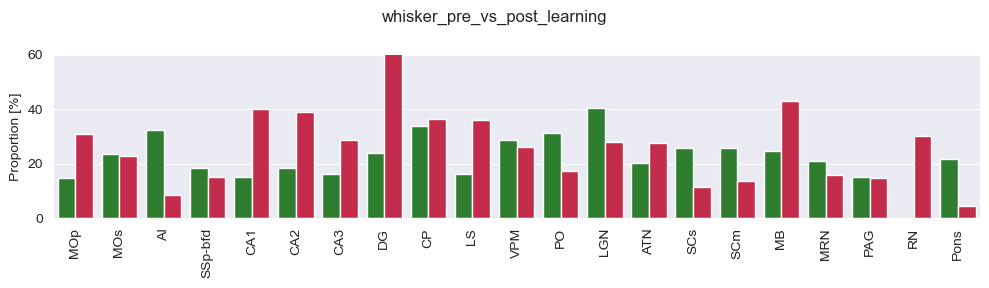

In [32]:
roc_df_shared_areas_perc_both = roc_df_shared_areas_perc[roc_df_shared_areas_perc.direction.eq('positive')]

for anal_type in roc_df_shared_areas_perc_both['analysis_type'].unique():
    #fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    roc_df_all_areas_type = roc_df_shared_areas_perc_both[roc_df_shared_areas_perc_both['analysis_type']==anal_type]
    
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
        suffix = 'auditory'
    else:
        order=['positive', 'negative'] 
        suffix = 'positive'
    g = sns.catplot(
        data=roc_df_all_areas_type, 
        kind='bar',
        x='area_acronym_custom',
        y='proportion_signed',
        order=area_order_shared, 
        palette=['forestgreen','crimson'],
        #color=area_color_list,
        #row='direction',
        hue='reward_group',
        hue_order=['R+','R-'],
        height=2.5,
        aspect=4,
        errorbar=None, 
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set(ylim=(0, 60))
    g.tight_layout()
    g.set_xticklabels(rotation=90)
    
    figname = f'brainwide_roc_reward_groups_{anal_type}_{suffix}.png'
    print(figname)
    g.savefig(os.path.join(FIGURE_PATH, figname))


    

#### Make a legend figure

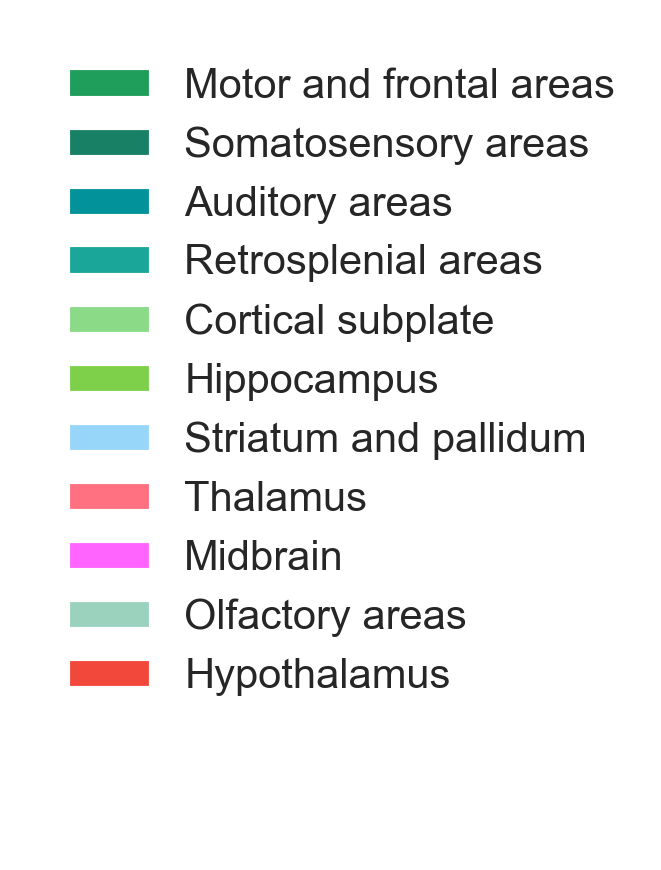

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def create_legend_figure(color_dict, rectangles=True, title="Legend"):
    """
    Create a legend figure from a dictionary mapping strings to colors.

    Parameters:
        color_dict (dict): A dictionary mapping strings to colors (e.g., {"Label": "#ff0000"}).
        rectangles (bool): If True, use colored rectangles; otherwise, color the text directly.
        title (str): Title for the legend figure.

    Returns:
        matplotlib.figure.Figure: A figure containing the legend.
    """
    fig, ax = plt.subplots(figsize=(2,3), dpi=300)
    ax.axis('off')  # Turn off the axes for a cleaner look   

    legend_elements = [Patch(facecolor=color, label=label) for label, color in color_dict.items()]
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, title=title)
    
    return fig

area_groups = {
    'Motor and frontal areas': ['MOp', 'MOs', 'FRP', 'ACA', 'PL', 'ORB', 'AI'],
    'Somatosensory areas': ['SSp-bfd', 'SSs', 'SSp-m', 'SSp-n', 'SSp-ul', 'SSp-ll', 'SSp-tr', 'SSp-un'],
    'Auditory areas': ['AUD'],
    'Retrosplenial areas': ['RSP'],
    'Cortical subplate': ['CLA', 'EP'],
    'Hippocampus': ['CA1', 'CA2', 'CA3'],
    'Striatal and pallidum': ['CP', 'STR', 'ACB', 'CEA', 'LS', 'SF', 'GPe', 'PAL', 'MS'],
    'Thalamus': ['VPL', 'VPM', 'AV', 'LD', 'RT', 'PO', 'LGN'],
    'Midbrain': ['MRN', 'PAG', 'SCs', 'SCm'],
    'Olfactory areas': ['AON', 'OLF', 'PIR'],
    'Hypothalamus': ['ZI']
}

color_dict_legend = {
    'Motor and frontal areas': '#1f9d5a',
    'Somatosensory areas': '#188064',
    'Auditory areas': '#019399',
    'Retrosplenial areas': '#1aa698',
    'Cortical subplate': '#8ada87',
    'Hippocampus': '#7ed04b',
    'Striatum and pallidum': '#98d6f9',
    'Thalamus': '#ff7080',
    'Midbrain': '#ff64ff',
    'Olfactory areas': '#9ad2bd',
    'Hypothalamus': '#f2483b'
}
color_palette = ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#9ad2bd', '#f2483b']


# Generate legend figure with rectangles
fig = create_legend_figure(color_dict_legend, rectangles=True, title='')
fig.tight_layout()
plt.show()
figname = 'allen_area_group_legend.png'
fig.savefig(os.path.join(FIGURE_PATH, figname), dpi=300, bbox_inches='tight')
figname = 'allen_area_group_legend.svg'
fig.savefig(os.path.join(FIGURE_PATH, figname), dpi=300, bbox_inches='tight')


# Compare before and after learning
#### Average number of selective units, pre vs post

C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\3764124279.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_npre['direction'] = roc_df_npre['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
C:\Users\mhamon\AppData\Local\Temp\ipykernel_20336\3764124279.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_nact['direction'] = roc_df_nact['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
C:\Users\mhamon\AppDa

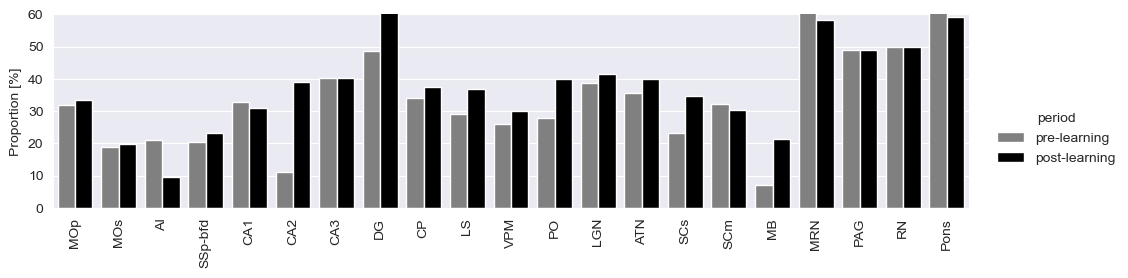

In [34]:
reward_group = 'R-'
stim_type = 'auditory'
roc_df_shared_areas_perc_both_direction = roc_df_shared_areas_perc[roc_df_shared_areas_perc.reward_group.eq(reward_group)]

# Pre learning ROC results
roc_df_npre = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_passive_pre'.format(stim_type)]
roc_df_npre['direction'] = roc_df_npre['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_npre = roc_df_npre.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_npre['period'] = 'pre-learning'

# Active learning ROC results
roc_df_nact = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_active'.format(stim_type)]
roc_df_nact['direction'] = roc_df_nact['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_nact = roc_df_nact.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_nact['period'] = 'active'

# Post learning ROC results
roc_df_npost = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_passive_post'.format(stim_type)]
roc_df_npost['direction'] = roc_df_npost['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_npost = roc_df_npost.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_npost['period'] = 'post-learning'

# Combine
roc_pre_vs_post_df = pd.concat([roc_df_npre, roc_df_nact, roc_df_npost])
roc_pre_vs_post_df.reset_index(inplace=True)

# Plot pre. vs post
df = roc_pre_vs_post_df[roc_pre_vs_post_df.direction=='both']
g = sns.catplot(
    data=df, 
    kind='bar',
    x='area_acronym_custom',
    y='proportion',
    order=area_order_shared, 
    hue='period',
    hue_order=['pre-learning','post-learning'],
    palette=['grey','k'],
    height=2.5,
    aspect=4,
    errorbar=None, 
    legend=True,
    legend_out=True,
    seed=42
)
g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(0, 60))
g.tight_layout()
g.set_xticklabels(rotation=90)

if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'

from scipy.stats import chi2_contingency

for area in df['area_acronym_custom'].unique():
    try:
        cond1_prop = df[(df.area_custom==area)&(df.analysis_type=='whisker_passive_pre')]['proportion'].values[0]
        cond2_prop = df[(df.area_custom==area)&(df.analysis_type=='whisker_passive_post')]['proportion'].values[0]
    except:
        continue
        
    contingency_table = np.array([
        [cond1_prop, 100-cond1_prop],
        [cond2_prop, 100-cond2_prop]
    ])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    #if p_value < 0.05:
    print(area, '- Chi-sq. statistic', chi2, 'p-value', p_value, 'dof', dof, 'expected frequencies:', expected)

figname = f'brainwide_roc_{reward_suffix}_npre_vs_npost_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))

#### Number of units that are became selective post-learning vs. pre-learning

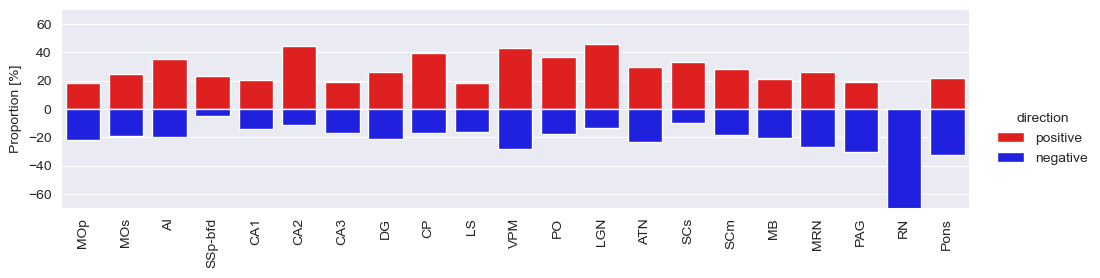

In [37]:
reward_group = 'R+'
stim_type = 'auditory'
roc_df_shared_areas_perc_prepost = roc_df_shared_areas_perc[(roc_df_shared_areas_perc.reward_group.eq(reward_group)) 
                                & (roc_df_shared_areas_perc.analysis_type.eq(f'{stim_type}_pre_vs_post_learning'))]

# Plot pre. vs post
g = sns.catplot(
    data=roc_df_shared_areas_perc_prepost, 
    kind='bar',
    x='area_acronym_custom',
    y='proportion_signed',
    order=area_order_shared, 
    hue='direction',
    hue_order=['positive','negative'],
    palette=['red','blue'],
    height=2.5,
    aspect=4,
    errorbar=None, 
    legend=True,
    legend_out=True,
    dodge=False
)
g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(-70, 70))
g.tight_layout()
g.set_xticklabels(rotation=90)

if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'

figname = f'brainwide_roc_{reward_suffix}_across_learning_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))

#